In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
data = pd.read_csv('2017_new.csv').dropna()
data['date_time'] = data['date'] + ' ' + data['time']
data['date_time'] = pd.to_datetime(data.date_time,format='%d/%m/%Y %H:%M:%S')
data['date'] = pd.to_datetime(data.date,format='%d/%m/%Y')

In [3]:
data = data.sort_values(by='date_time')
data['weekday'] = data['date'].dt.day_name()
data["month"]= data["date"].dt.month
data["year"]= data["date"].dt.year

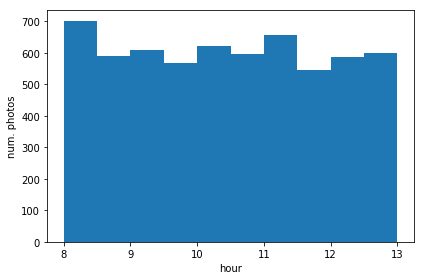

In [4]:
#Time histogram per year (all bonds)
#plt.figure(figsize=(20,25))
k = 1
hours_list = []
for i in range(1,len(data)):
    hours_list.append(((data['date_time'][i] - data['date'][i]).total_seconds())/3600.)
    k += 1 
plt.hist(hours_list, bins=10)
plt.xlabel('hour')
plt.ylabel('num. photos')
#plt.savefig('all_bonds_2016.pdf')
plt.tight_layout()
plt.show()
#plt.close()

In [5]:
interval=0.5
A={}
k=1
num=(13.-8.)/interval + 1
h_lin=np.linspace(8.,13.,num)
for i in h_lin:

    for j in range(len(hours_list)):
        if hours_list[j] <= float(i) + interval and hours_list[j] > float(i):
            if k in A.keys():
                A[k].append(hours_list[j])
            else:
                A[k] = [hours_list[j]]
    k+=1

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


In [6]:
probabilidades=np.zeros(len(A.keys()))
ind=0
for i in A.keys():
    probabilidades[ind]=len(A[i])/len(hours_list)
    ind+=1

In [7]:
def gen_hist(datos,interval):
    A={}
    k=1
    num=(13.-8.)/interval + 1
    h_lin=np.linspace(8.,13.,num)
    for i in h_lin:
        for j in range(len(datos)):
            if datos[j] <= float(i) + interval and datos[j] > float(i):
                if k in A.keys():
                    A[k].append(datos[j])
                else:
                    A[k] = [datos[j]]
        k+=1
    return A
def Proba_hist(diccionario):
    probabilidades=np.zeros(len(diccionario.keys()))
    ind=0
    for i in diccionario.keys():
        probabilidades[ind]=len(diccionario[i])/len(hours_list)
        ind+=1
    return probabilidades
def Entropy(proba):
    H= -proba*np.log(proba)
    return np.sum(H)
def Cross_entropy(pi,qi):
    I = -pi*np.log(qi)
    return np.sum(I)

In [8]:
Cross_entropy(probabilidades,1.0/len(probabilidades))

2.3025850929940455

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


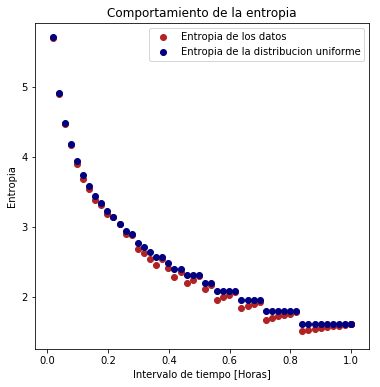

In [9]:
#print(Entropy(probabilidades),np.log(len(probabilidades)))
diferencia=np.zeros(len(np.linspace(1.0/60.0,1.0)))
Kullback_Leibler=np.zeros(len(np.linspace(1.0/60.0,1.0)))
Id=0
plt.figure(figsize=(6,6))
for interval in np.linspace(1.0/60,1.0):
    d = gen_hist(hours_list,interval)
    prob = Proba_hist(d)
    H = Entropy(prob)
    H_q_p = Cross_entropy(prob,1.0/len(prob))
    Kullback_Leibler[Id]= (H_q_p - H)
    diferencia[Id]=np.abs(H-np.log(len(prob)))/np.log(len(prob))
    Id+=1
    plt.scatter(interval,H,color="firebrick")
    plt.scatter(interval,np.log(len(prob)),color="navy")
plt.scatter(interval,H,color="firebrick",label="Entropia de los datos")
plt.scatter(interval,np.log(len(prob)),color="navy",label="Entropia de la distribucion uniforme")
plt.xlabel("Intervalo de tiempo [Horas]")
plt.ylabel("Entropia")
plt.title("Comportamiento de la entropia")
plt.savefig("Entropy.png")
plt.legend()
plt.show()

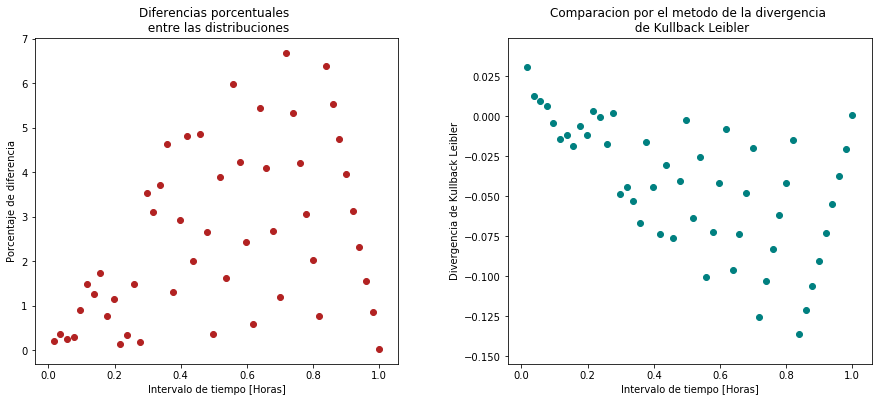

In [10]:
#plt.boxplot(diferencia*100)
plt.figure(figsize=(15,6))
plt.subplots_adjust(wspace = 0.3)
plt.subplot(1,2,1)
plt.scatter(np.linspace(1.0/60.0,1.0),diferencia*100,color="firebrick")
plt.title("Diferencias porcentuales \n entre las distribuciones")
plt.xlabel("Intervalo de tiempo [Horas]")
plt.ylabel("Porcentaje de diferencia")
#plt.fill(np.linspace(1.0/60.0,1.0),diferencia*100)
plt.subplot(1,2,2)
plt.scatter(np.linspace(1.0/60.0,1.0),Kullback_Leibler,color="teal")
plt.title("Comparacion por el metodo de la divergencia \n de Kullback Leibler")
plt.xlabel("Intervalo de tiempo [Horas]")
plt.ylabel("Divergencia de Kullback Leibler")
#plt.fill(np.linspace(1.0/60.0,1.0),Kullback_Leibler)
plt.savefig("Diff.png")
plt.show()

In [11]:
#kf = KFold(n_splits=2)
X = (np.array(np.sort(hours_list))).reshape(-1,1)
X_train, X_test, y_t, y_t2 = train_test_split(X, X, test_size=0.2)

In [12]:
# tophat KDE
X_plot = np.linspace(8, 13, 1000)[:, np.newaxis]

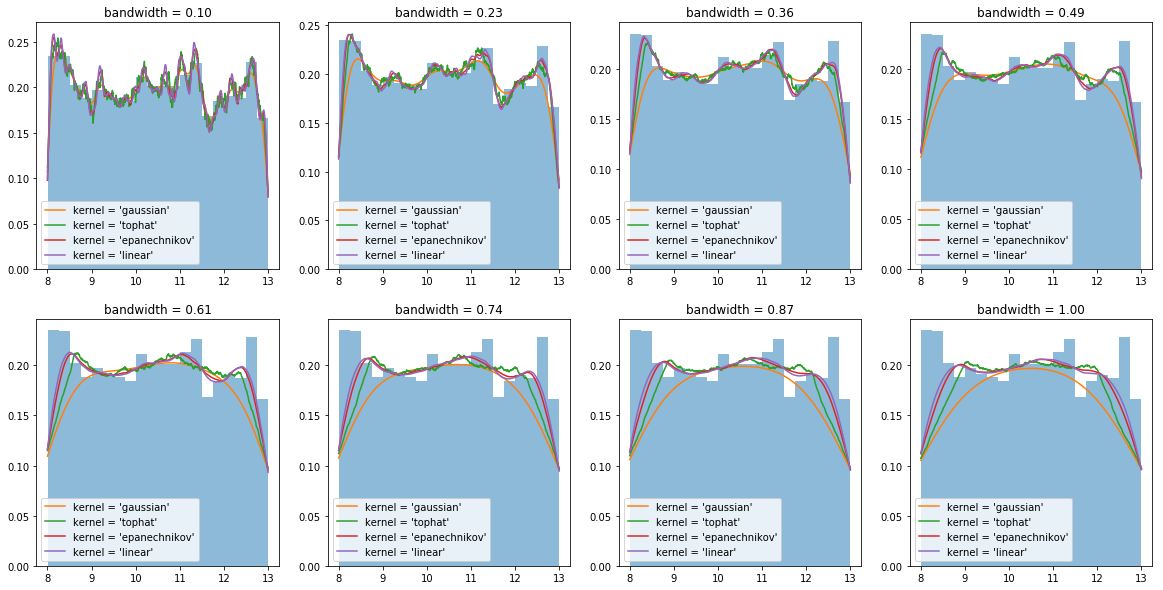

In [13]:
plt.figure(figsize=(20,10))
k = 1
for bw in np.linspace(0.1,1.0,8):
    plt.subplot(2,4,k)
    plt.title("bandwidth = {0:.2f}".format(bw))
    plt.hist(X_train, bins=20, density='True',alpha=0.5)
    for kernel in ['gaussian', 'tophat', 'epanechnikov', 'linear']:
        kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(X_train)
        log_dens = kde.score_samples(X_plot)
        plt.plot(X_plot[:, 0], np.exp(log_dens), '-', label="kernel = '{0}'".format(kernel))
    k += 1
    plt.legend()
plt.savefig("Ajustes.png")
plt.show()